In [1]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, load_model
from PIL import Image, ImageFile, UnidentifiedImageError
import scipy
import logging

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
drive.mount('/content/drive')
base_folder_path = '/content/drive/My Drive/dataset/scrape'
train_folder_path = os.path.join(base_folder_path, 'Train')
val_folder_path = os.path.join(base_folder_path, 'Validation')
test_folder_path = os.path.join(base_folder_path, 'Test')


Mounted at /content/drive


In [3]:
def read_image_files_in_folder(folder_path):
    files = os.listdir(folder_path)
    images = []
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(folder_path, file)
            image = Image.open(file_path)
            images.append(image)
            print(f'Reading image: {file}')
            plt.imshow(image)
            plt.show()
    return images

train_images = read_image_files_in_folder(train_folder_path)
val_images = read_image_files_in_folder(val_folder_path)
test_images = read_image_files_in_folder(test_folder_path)

In [4]:
def count_folders_in_directory(directory_path):
    items = os.listdir(directory_path)
    folders = [item for item in items if os.path.isdir(os.path.join(directory_path, item))]
    return len(folders), folders

# Hitung jumlah folder dalam folder train
train_folder_count, train_folders = count_folders_in_directory(train_folder_path)
print(f'Number of folders in train: {train_folder_count}')
print('Folders:', train_folders)

# Hitung jumlah folder dalam folder validation
val_folder_count, val_folders = count_folders_in_directory(val_folder_path)
print(f'Number of folders in val: {val_folder_count}')
print('Folders:', val_folders)

# Hitung jumlah folder dalam folder test
test_folder_count, test_folders = count_folders_in_directory(test_folder_path)
print(f'Number of folders in test: {test_folder_count}')
print('Folders:', test_folders)


Number of folders in train: 9
Folders: ['Acne', 'Melanoma', 'Eczema', 'Herpes', 'Lupus', 'Tinea Ringworm', 'Urticaria Hives', 'Warts', 'Healthy']
Number of folders in val: 9
Folders: ['Acne', 'Melanoma', 'Eczema', 'Herpes', 'Lupus', 'Tinea Ringworm', 'Urticaria Hives', 'Warts', 'Healthy']
Number of folders in test: 9
Folders: ['Healthy', 'Acne', 'Melanoma', 'Eczema', 'Herpes', 'Lupus', 'Tinea Ringworm', 'Urticaria Hives', 'Warts']


In [5]:
# Custom Data Generator to handle corrupted images
class SafeImageDataGenerator(ImageDataGenerator):
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=self.dtype)
        batch_y = np.zeros((len(index_array), self.num_classes), dtype=self.dtype)
        valid_samples = 0

        for i, j in enumerate(index_array):
            fname = self.filepaths[j]
            try:
                img = self.load_img(fname, color_mode=self.color_mode,
                                    target_size=self.target_size,
                                    interpolation=self.interpolation)
                x = self.img_to_array(img)
                x = self.standardize(x)
                batch_x[valid_samples] = x
                batch_y[valid_samples, self.classes[j]] = 1.
                valid_samples += 1
            except (OSError, ValueError, Image.UnidentifiedImageError) as e:
                logger.warning(f"Skipping corrupted image: {fname}, Error: {e}")

        return batch_x[:valid_samples], batch_y[:valid_samples]

In [6]:
train_datagen = SafeImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = SafeImageDataGenerator(rescale=1.0/255.0)
test_datagen = SafeImageDataGenerator(rescale=1.0/255.0)

# Create the generators
train_generator = train_datagen.flow_from_directory(
    train_folder_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_folder_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_folder_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1268 images belonging to 9 classes.
Found 361 images belonging to 9 classes.
Found 196 images belonging to 9 classes.


In [7]:
# Count folders in train, validation, and test directories
train_folder_count, train_folders = count_folders_in_directory(train_folder_path)
print(f'Number of folders in train: {train_folder_count}')
print('Folders:', train_folders)

val_folder_count, val_folders = count_folders_in_directory(val_folder_path)
print(f'Number of folders in val: {val_folder_count}')
print('Folders:', val_folders)

test_folder_count, test_folders = count_folders_in_directory(test_folder_path)
print(f'Number of folders in test: {test_folder_count}')
print('Folders:', test_folders)


Number of folders in train: 9
Folders: ['Acne', 'Melanoma', 'Eczema', 'Herpes', 'Lupus', 'Tinea Ringworm', 'Urticaria Hives', 'Warts', 'Healthy']
Number of folders in val: 9
Folders: ['Acne', 'Melanoma', 'Eczema', 'Herpes', 'Lupus', 'Tinea Ringworm', 'Urticaria Hives', 'Warts', 'Healthy']
Number of folders in test: 9
Folders: ['Healthy', 'Acne', 'Melanoma', 'Eczema', 'Herpes', 'Lupus', 'Tinea Ringworm', 'Urticaria Hives', 'Warts']


In [8]:
# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(input_shape=(300, 300, 3),
                                include_top=False,
                                weights='imagenet')

# Freeze some layers of the pre-trained model
for layer in pre_trained_model.layers[249:]:
    layer.trainable = True

# Function to create the final model
def create_final_model(pre_trained_model):
    output = pre_trained_model.output
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(output)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(9, activation='softmax')(x)

    model = Model(inputs=pre_trained_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the final model
model = create_final_model(pre_trained_model)

# # Define callbacks
# checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    verbose=1)


87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/20
40/40 [==============================] - 580s 13s/step - loss: 2.3763 - accuracy: 0.2279 - val_loss: 2.0939 - val_accuracy: 0.1884
Epoch 2/20
40/40 [==============================] - 69s 2s/step - loss: 1.7462 - accuracy: 0.4038 - val_loss: 1.7985 - val_accuracy: 0.3102
Epoch 3/20
40/40 [==============================] - 70s 2s/step - loss: 1.4130 - accuracy: 0.5331 - val_loss: 1.4170 - val_accuracy: 0.5429
Epoch 4/20
40/40 [==============================] - 66s 2s/step - loss: 1.1474 - accuracy: 0.6285 - val_loss: 1.1557 - val_accuracy: 0.6343
Epoch 5/20
40/40 [==============================] - 67s 2s/step - loss: 0.9031 - accuracy: 0.7153 - val_loss: 1.0522 - val_accuracy: 0.6759
Epoch 6/20
40/40 [==============================] - 70s 2s/step - loss: 0.7230 - accuracy: 0.7729 - val_loss: 0.8898 - val_accuracy: 0.7452
Epoch 7/20
40/40 [==============================] - 68s 2s/step - loss: 0.5917 - accuracy: 0.

7/7 [==============================] - 62s 10s/step


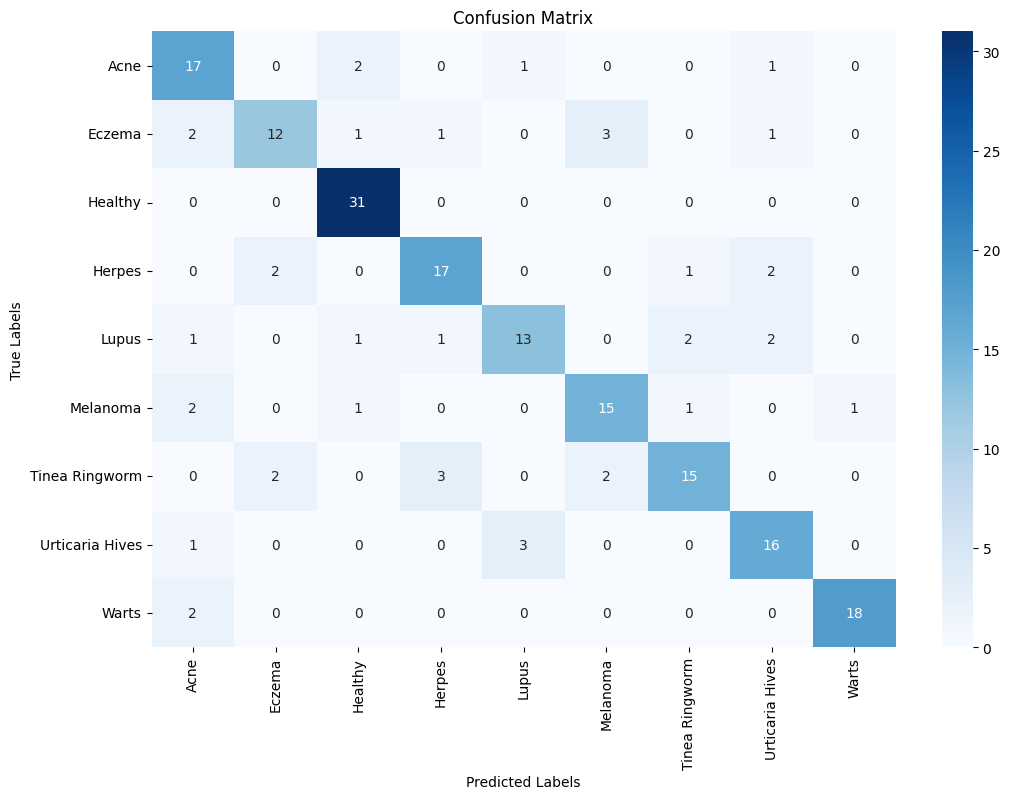

Classification Report
                 precision    recall  f1-score   support

           Acne       0.68      0.81      0.74        21
         Eczema       0.75      0.60      0.67        20
        Healthy       0.86      1.00      0.93        31
         Herpes       0.77      0.77      0.77        22
          Lupus       0.76      0.65      0.70        20
       Melanoma       0.75      0.75      0.75        20
 Tinea Ringworm       0.79      0.68      0.73        22
Urticaria Hives       0.73      0.80      0.76        20
          Warts       0.95      0.90      0.92        20

       accuracy                           0.79       196
      macro avg       0.78      0.77      0.77       196
   weighted avg       0.79      0.79      0.78       196



In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels from the test generator
y_true = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=target_names))


In [10]:
model.save('InceptionV3_model(scrape).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 3s 3s/step


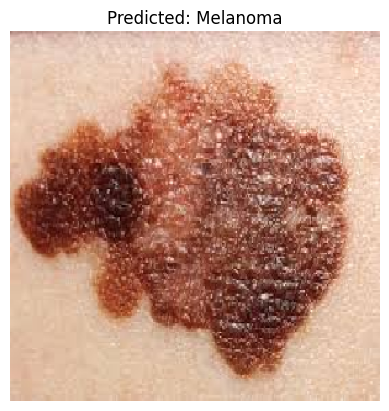

Predicted class: Melanoma
Predicted probabilities:
Acne: 0.0000
Eczema: 0.0000
Healthy: 0.0000
Herpes: 0.0000
Lupus: 0.0000
Melanoma: 0.9999
Tinea Ringworm: 0.0000
Urticaria Hives: 0.0000
Warts: 0.0000


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'melanoma1.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 47ms/step


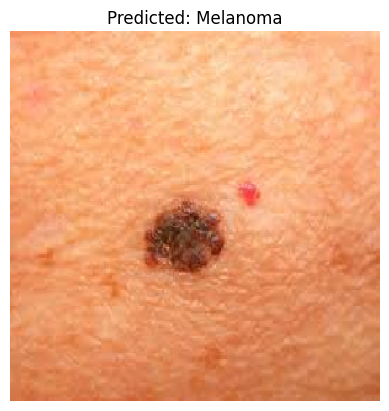

Predicted class: Melanoma
Predicted probabilities:
Acne: 0.0000
Eczema: 0.0000
Healthy: 0.0000
Herpes: 0.0000
Lupus: 0.0000
Melanoma: 1.0000
Tinea Ringworm: 0.0000
Urticaria Hives: 0.0000
Warts: 0.0000


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'melanoma2.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 65ms/step


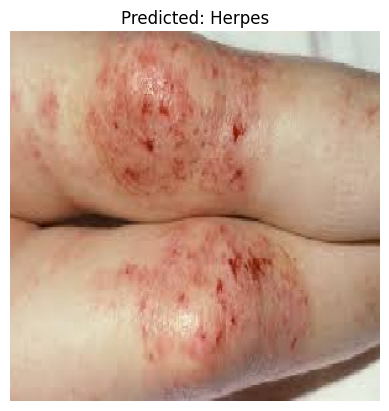

Predicted class: Herpes
Predicted probabilities:
Acne: 0.0070
Eczema: 0.0732
Healthy: 0.0007
Herpes: 0.7165
Lupus: 0.1597
Melanoma: 0.0021
Tinea Ringworm: 0.0007
Urticaria Hives: 0.0215
Warts: 0.0186


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'eczema1.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 69ms/step


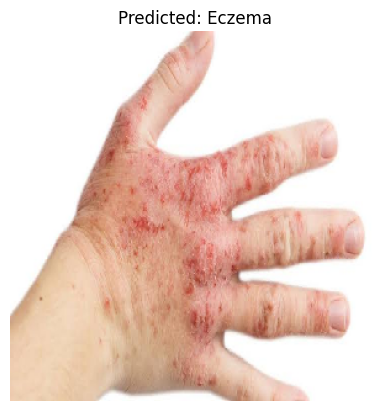

Predicted class: Eczema
Predicted probabilities:
Acne: 0.1237
Eczema: 0.8045
Healthy: 0.0105
Herpes: 0.0028
Lupus: 0.0217
Melanoma: 0.0301
Tinea Ringworm: 0.0015
Urticaria Hives: 0.0040
Warts: 0.0013


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'eczema2.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 40ms/step


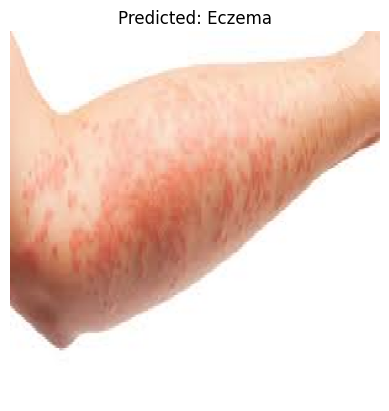

Predicted class: Eczema
Predicted probabilities:
Acne: 0.0088
Eczema: 0.6639
Healthy: 0.0036
Herpes: 0.0124
Lupus: 0.0102
Melanoma: 0.0021
Tinea Ringworm: 0.0063
Urticaria Hives: 0.2849
Warts: 0.0078


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'eczema3.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 99ms/step


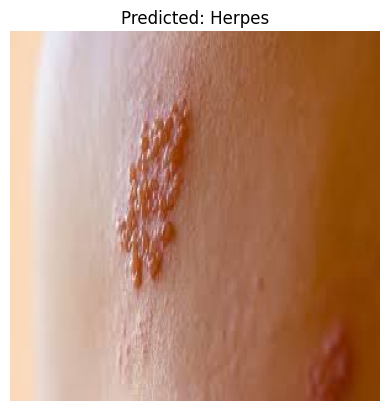

Predicted class: Herpes
Predicted probabilities:
Acne: 0.0037
Eczema: 0.0000
Healthy: 0.0000
Herpes: 0.9958
Lupus: 0.0001
Melanoma: 0.0000
Tinea Ringworm: 0.0001
Urticaria Hives: 0.0002
Warts: 0.0001


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'herpes1.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 41ms/step


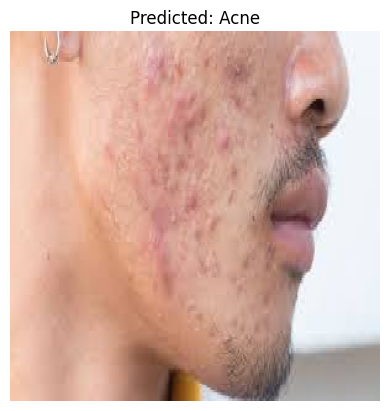

Predicted class: Acne
Predicted probabilities:
Acne: 0.9898
Eczema: 0.0012
Healthy: 0.0001
Herpes: 0.0008
Lupus: 0.0003
Melanoma: 0.0035
Tinea Ringworm: 0.0037
Urticaria Hives: 0.0005
Warts: 0.0002


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'jerawat1.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 41ms/step


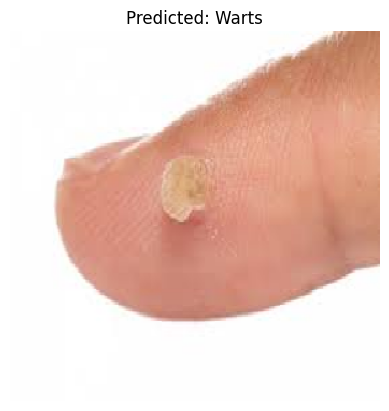

Predicted class: Warts
Predicted probabilities:
Acne: 0.0072
Eczema: 0.0099
Healthy: 0.0006
Herpes: 0.0027
Lupus: 0.0001
Melanoma: 0.0001
Tinea Ringworm: 0.0010
Urticaria Hives: 0.0003
Warts: 0.9781


In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'kutil1.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 99ms/step


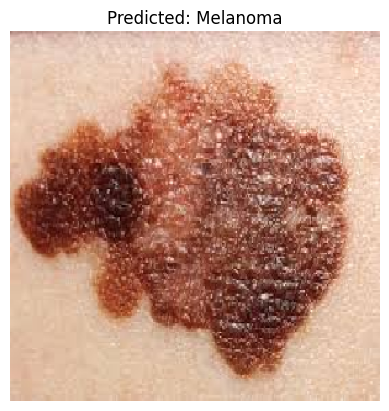

Predicted class: Melanoma
Predicted probabilities:
Acne: 0.0000
Eczema: 0.0000
Healthy: 0.0000
Herpes: 0.0000
Lupus: 0.0000
Melanoma: 0.9999
Tinea Ringworm: 0.0000
Urticaria Hives: 0.0000
Warts: 0.0000


In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'melanoma1.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 39ms/step


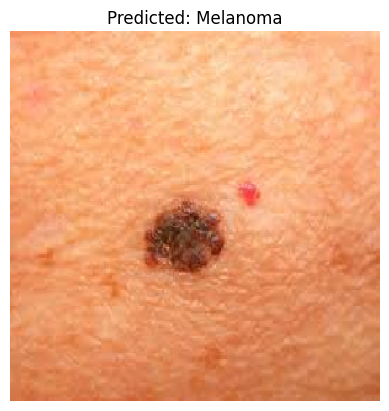

Predicted class: Melanoma
Predicted probabilities:
Acne: 0.0000
Eczema: 0.0000
Healthy: 0.0000
Herpes: 0.0000
Lupus: 0.0000
Melanoma: 1.0000
Tinea Ringworm: 0.0000
Urticaria Hives: 0.0000
Warts: 0.0000


In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'melanoma2.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 151ms/step


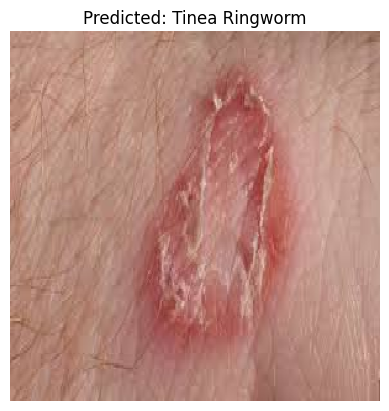

Predicted class: Tinea Ringworm
Predicted probabilities:
Acne: 0.0001
Eczema: 0.0000
Healthy: 0.0000
Herpes: 0.0001
Lupus: 0.0000
Melanoma: 0.0000
Tinea Ringworm: 0.9994
Urticaria Hives: 0.0001
Warts: 0.0002


In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'tinea1.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 41ms/step


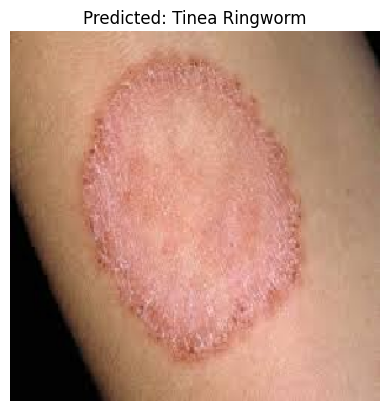

Predicted class: Tinea Ringworm
Predicted probabilities:
Acne: 0.0000
Eczema: 0.0000
Healthy: 0.0000
Herpes: 0.0000
Lupus: 0.0000
Melanoma: 0.0000
Tinea Ringworm: 1.0000
Urticaria Hives: 0.0000
Warts: 0.0000


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'tinea2.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 51ms/step


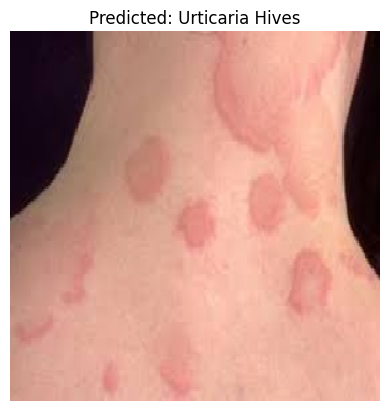

Predicted class: Urticaria Hives
Predicted probabilities:
Acne: 0.0002
Eczema: 0.0004
Healthy: 0.0000
Herpes: 0.0001
Lupus: 0.0000
Melanoma: 0.0000
Tinea Ringworm: 0.0008
Urticaria Hives: 0.9984
Warts: 0.0001


In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'urticaria1.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 44ms/step


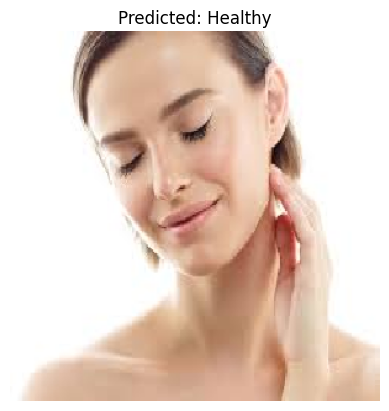

Predicted class: Healthy
Predicted probabilities:
Acne: 0.0247
Eczema: 0.0003
Healthy: 0.9398
Herpes: 0.0003
Lupus: 0.0052
Melanoma: 0.0289
Tinea Ringworm: 0.0001
Urticaria Hives: 0.0003
Warts: 0.0003


In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'healthy1.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")


1/1 [==============================] - 0s 40ms/step


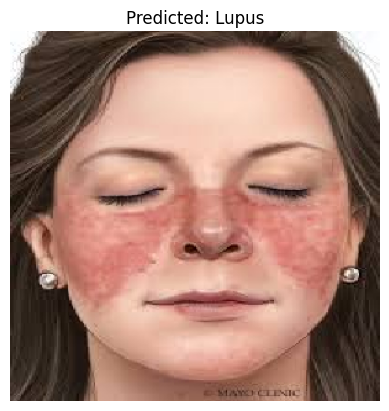

Predicted class: Lupus
Predicted probabilities:
Acne: 0.0000
Eczema: 0.0001
Healthy: 0.0000
Herpes: 0.0000
Lupus: 0.9996
Melanoma: 0.0003
Tinea Ringworm: 0.0000
Urticaria Hives: 0.0000
Warts: 0.0000


In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'lupus1.jpeg'
img = load_img(img_path, target_size=(300, 300))  # Resize to match the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict the class of the image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
class_labels = list(test_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image and the prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label}')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print('Predicted probabilities:')
predicted_probabilities = predictions[0]

# Menampilkan probabilitas untuk setiap kelas
for class_label, probability in zip(class_labels, predicted_probabilities):
    print(f"{class_label}: {probability:.4f}")
